In [1]:
%load_ext autoreload
%autoreload 2
%load_ext autotime
%matplotlib inline

time: 511 ms


In [3]:
from tictactoe import TicTacToe
from qlearning import q_learning

import matplotlib.pyplot as plt

time: 864 ms


### 1.1 Q-learning for Tic Tac Toe (3x3) (играем против рандомной стратегии)

In [4]:
env = TicTacToe(3, 3, 3)
env.reset()

time: 721 µs


In [54]:
q, r = q_learning(env, crosses=True, n_episodes=10000, logging_freq=1000, estimate_episodes=1000)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
time: 7.98 s


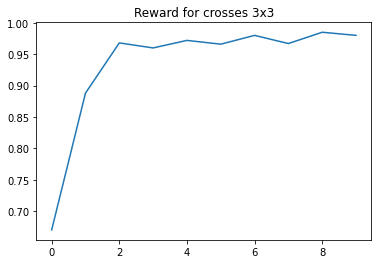

time: 356 ms


In [55]:
plt.plot(r)
plt.title('Reward for crosses 3x3')
plt.show()

In [5]:
env.reset()
q, r = q_learning(env, crosses=False, n_episodes=10000, logging_freq=1000, estimate_episodes=1000)

1000 -8.617
2000 -9.615
3000 -9.956
4000 -9.989
5000 -10.0
6000 -10.0
7000 -10.0
8000 -10.0
9000 -10.0
10000 -10.0
time: 6.71 s


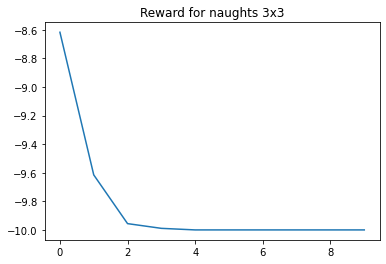

time: 276 ms


In [6]:
plt.plot(r)
plt.title('Reward for naughts 3x3')
plt.show()

### 1.2 Q-learning for Tic Tac Toe (4x4)

In [81]:
env4 = TicTacToe(4, 4, 4)
env4.reset()

time: 1.41 ms


In [61]:
q, r = q_learning(env4, crosses=True, n_episodes=10000, logging_freq=1000, estimate_episodes=1000)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
time: 13 s


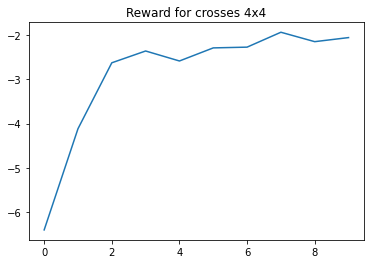

time: 177 ms


In [62]:
plt.plot(r)
plt.title('Reward for crosses 4x4')
plt.show()

In [84]:
env4.reset()
q, r = q_learning(env4, crosses=False, n_episodes=10000, logging_freq=1000, estimate_episodes=1000)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
time: 18.8 s


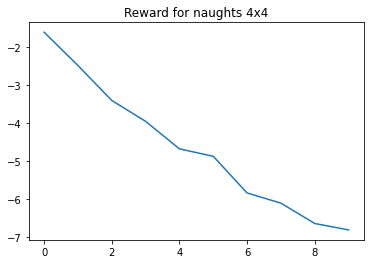

time: 180 ms


In [85]:
plt.plot(r)
plt.title('Reward for naughts 4x4')
plt.show()

### 1.2 Q-learning for Tic Tac Toe (5x5)

In [86]:
env5 = TicTacToe(5, 5, 4)
env5.reset()

time: 527 µs


In [15]:
q, r = q_learning(env5, crosses=True, n_episodes=10000, logging_freq=1000, estimate_episodes=1000)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
time: 22.2 s


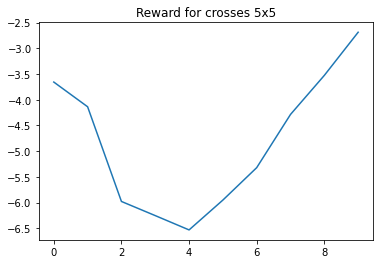

time: 214 ms


In [16]:
plt.plot(r)
plt.title('Reward for crosses 5x5')
plt.show()

In [87]:
env5.reset()
q, r = q_learning(env5, crosses=False, n_episodes=10000, logging_freq=1000, estimate_episodes=1000)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
time: 45.3 s


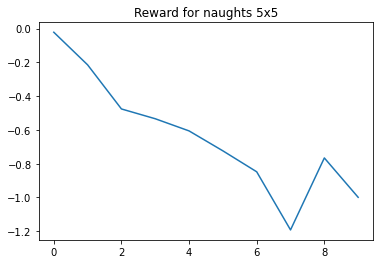

time: 202 ms


In [88]:
plt.plot(r)
plt.title('Reward for naughts 5x5')
plt.show()

### Вывод: для 3х3 получаем достойное качество в результате работы алгоритма.

### Для случаев 4х4 и 5х5 качество реворд растет с количеством эпизодов, но с некоторыми колебаниями. Требуется большое количество игр, чтобы добиться хорошего качества

## 2. DQN & Dueling DQN

### 2.1 DQN против рандомной стратегии

In [42]:
from dqn import DQN, DuelingDQN, ReplayMemory
from utils import estimate_return_dqn, sample_action_dqn
import torch.optim as optim
import torch
import torch.nn.functional as F
import random
import numpy as np

time: 961 µs


In [43]:
 def run_episode(env, model, memory, crosses=True, render=False):
    env.reset()

    s = env.getHash()
    actions = env.getEmptySpaces().tolist()
    board = env.tensor_board()

    done = False

    while not done: 

        if crosses:
            # crosses: our move
            s = env.getHash()
            board = env.tensor_board()
            with torch.no_grad():
                a = sample_action_dqn(model, env)
            s_prime, r, done, _ = env.step(a)

            if done:
                # we won
                next_board = env.tensor_board()
                experience = (board, env.int_from_action(a), r, next_board)
                memory.store(experience)

            # naughts: their move
            if not done:
                s_prime, r, done, _ = env.step(random.choice(s_prime[1]))
        
            next_board = env.tensor_board()

            experience = (board, env.int_from_action(a), -r if done else r, next_board)
            memory.store(experience)

        else:
            # crosses: their move
            actions = env.getEmptySpaces().tolist()
            s_prime, r, done, _ = env.step(random.choice(actions))

            if done:
                # we lost
                next_board = env.tensor_board()
                experience = (board, env.int_from_action(a), -r, next_board)

            # naughts: our move
            if not done:
                s = env.getHash()
                board = env.tensor_board()
                with torch.no_grad():
                    a = sample_action_dqn(model, env)
                s_prime, r, done, _ = env.step(a)

            next_board = env.tensor_board()
            experience = (board, env.int_from_action(a), r, next_board)
            memory.store(experience)

            board = next_board
            s = s_prime
        
        if render:
            env.printBoard()  

    return memory

def learn(model, memory, batch_size, episode_num, gamma=0.5):
    if len(memory) < batch_size:
        return

    s_batch, a_batch, r_batch, s_prime_batch = memory.sample(batch_size)

    q = model(s_batch).gather(1, a_batch).reshape([batch_size])
    q_next = r_batch
    q_next[q_next == 0] += gamma * model(s_prime_batch[q_next == 0]).detach().max(1)[0]

    optimizer.zero_grad()

    loss = F.smooth_l1_loss(q, q_next)
    loss.backward()

    optimizer.step()

time: 2.88 ms


In [44]:
memory_cap = 10000
gamma = 0.8
batch_size = 64
n_episodes = 10000
logging_freq = 500
epochs = 10000

time: 863 µs


In [45]:
env = TicTacToe(3, 3, 3)
env.reset()
net = DQN(3 * 3)
optimizer = optim.Adam(net.parameters(), 0.001)
memory = ReplayMemory(memory_cap)
crosses = True

rewards = []

for i in range(1, epochs + 1):
    memory = run_episode(env, net, memory, crosses=crosses)
    learn(net, memory, batch_size, n_episodes, gamma)
    if not i % logging_freq:
        rewards.append(estimate_return_dqn(env, net, crosses=crosses))

time: 1min 48s


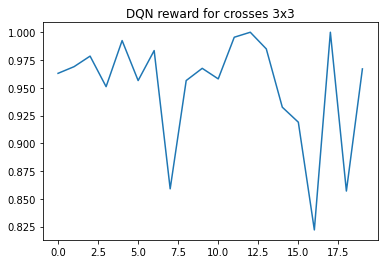

time: 245 ms


In [46]:
plt.plot(rewards)
plt.title("DQN reward for crosses 3x3")
plt.show()

In [49]:
env = TicTacToe(3, 3, 3)
env.reset()
net = DQN(3 * 3)
optimizer = optim.Adam(net.parameters(), 0.001)
memory = ReplayMemory(memory_cap)
crosses = False

rewards = []

for i in range(1, epochs + 1):
    memory = run_episode(env, net, memory, crosses=crosses)
    learn(net, memory, batch_size, n_episodes, gamma)
    if not i % logging_freq:
        rewards.append(estimate_return_dqn(env, net, crosses=crosses))

time: 1min 49s


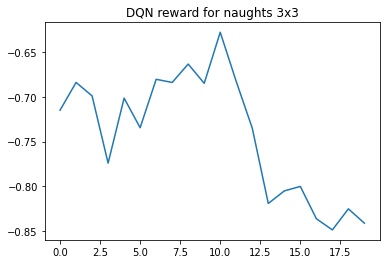

time: 224 ms


In [50]:
plt.plot(rewards)
plt.title("DQN reward for naughts 3x3")
plt.show()

In [27]:
env = TicTacToe(4, 4, 4)
env.reset()
net = DQN(4 * 4, kernel_size=3)
optimizer = optim.Adam(net.parameters(), 0.001)
memory = ReplayMemory(memory_cap)
crosses = True

rewards = []

for i in range(1, epochs + 1):
    memory = run_episode(env, net, memory, crosses=crosses)
    learn(net, memory, batch_size, n_episodes, gamma)
    if not i % logging_freq:
        rewards.append(estimate_return_dqn(env, net, crosses=crosses))

time: 2min 9s


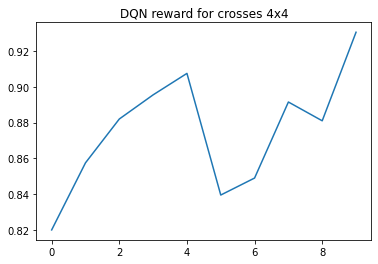

time: 189 ms


In [28]:
plt.plot(rewards)
plt.title("DQN reward for crosses 4x4")
plt.show()

In [29]:
env = TicTacToe(4, 4, 4)
env.reset()
net = DQN(4 * 4)
optimizer = optim.Adam(net.parameters(), 0.001)
memory = ReplayMemory(memory_cap)
crosses = False

rewards = []

for i in range(1, epochs + 1):
    memory = run_episode(env, net, memory, crosses=crosses)
    learn(net, memory, batch_size, n_episodes, gamma)
    if not i % logging_freq:
        rewards.append(estimate_return_dqn(env, net, crosses=crosses))

time: 2min 1s


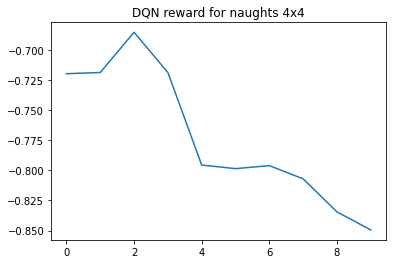

time: 234 ms


In [30]:
plt.plot(rewards)
plt.title("DQN reward for naughts 4x4")
plt.show()

### 2.2 Dueling DQN против рандомной стратегии

In [51]:
env = TicTacToe(4, 4, 4)
env.reset()
net = DuelingDQN(4 * 4, kernel_size=3)
optimizer = optim.Adam(net.parameters(), 0.001)
memory = ReplayMemory(memory_cap)
crosses = True

rewards = []

for i in range(1, epochs + 1):
    memory = run_episode(env, net, memory, crosses=crosses)
    learn(net, memory, batch_size, n_episodes, gamma)
    if not i % 1000:
        rewards.append(estimate_return_dqn(env, net, crosses=crosses))

time: 2min 22s


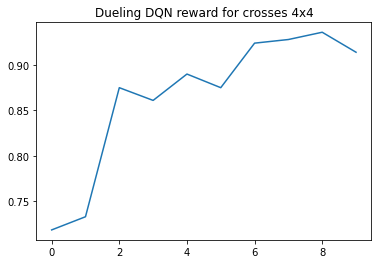

time: 185 ms


In [52]:
plt.plot(rewards)
plt.title("Dueling DQN reward for crosses 4x4")
plt.show()

In [40]:
env = TicTacToe(4, 4, 4)
env.reset()
net = DuelingDQN(4 * 4, kernel_size=3)
optimizer = optim.Adam(net.parameters(), 0.001)
memory = ReplayMemory(memory_cap)
crosses = False

rewards = []

for i in range(1, epochs + 1):
    memory = run_episode(env, net, memory, crosses=crosses)
    learn(net, memory, batch_size, n_episodes, gamma)
    if not i % 1000:
        print(i)
        rewards.append(estimate_return_dqn(env, net, crosses=crosses))

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
time: 2min 20s


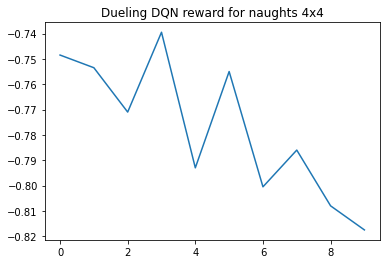

time: 229 ms


In [41]:
plt.plot(rewards)
plt.title("Dueling DQN reward for naughts 4x4")
plt.show()

### DQN и Dueling DQN лучше работают для задач большей размерности (4х4 и 5х5) - быстрее приходят к высокому (>0.8) реворду. Табличный q-learning больше подходит для задачи 3x3.

In [25]:
np.array(list(Q.values())).mean()

0.0

time: 18.1 ms


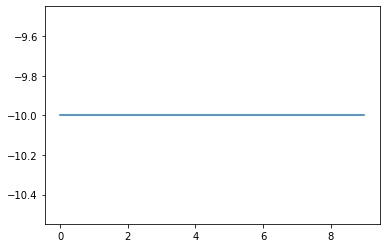

time: 175 ms


In [26]:
plt.plot(R)